# Calibrating the velocity field against observations 

In [1]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
import jax
from numpyro.infer import MCMC, NUTS, init_to_median
import corner
from getdist import plots
from scipy.stats import multivariate_normal

import csiborgtools

from flow_calibration import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

## LOS density & radial velocity plots 

In [ ]:
# fpath = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg = csiborgtools.flow.DataLoader("csiborg1", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg2 = csiborgtools.flow.DataLoader("csiborg2_main", "LOSS", fpath, paths, ksmooth=0)

In [ ]:
# ks = [115,  53,  77, 105,  26,  61,  86,  29,  80,  21]
ks = [19,  8, 15,  0, 16,  6, 48, 38, 26, 44]
# ks = [19]
# ks = np.random.choice(50, 10, replace=False)

# k = 6
for k in []:
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    # Get rid of vertical spacing
    fig.subplots_adjust(wspace=0)

    # Plot CSiBORG
    for i in range(loader_csiborg.los_density.shape[1]):
        axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, i, :], alpha=0.1, color="black")
        axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, i, :], alpha=0.1, color="black")

    # CSiBORG1
    axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, :, :].mean(axis=0), color="red", label="CSiBORG1")
    axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, :, :].mean(axis=0), color="red")

    # CSiBORG2
    axs[0].plot(loader_csiborg2.rdist, loader_csiborg2.los_density[k, :, :].mean(axis=0), color="violet", label="CSiBORG2")
    axs[1].plot(loader_csiborg2.rdist, loader_csiborg2.los_radial_velocity[k, :, :].mean(axis=0), color="violet")

    # Plot Carrick+2015
    axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[k, 0, :], color="blue", label="Carrick+2015")
    axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[k, 0, :] * 0.43, color="blue")


    # for i in range(2):
    #     label = "SN"
    #     rdist = loader_csiborg.cat["r_hMpc"][k]
    #     axs[i].axvline(rdist, color="violet", linestyle="--",
    #                 zorder=0, label=label)

    axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
    axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")

    axs[0].set_yscale("log")

    axs[0].legend(loc="upper right")
    axs[0].set_xlim(0, 200)

    fig.tight_layout(w_pad=0, h_pad=0)
    fig.savefig(f"../plots/LOSS_los_{k}.png", dpi=500, bbox_inches="tight")

    fig.show()

## Test running a model

In [37]:
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"

simname = "Carrick2015"
catalogue = "SFI_groups"
loader = csiborgtools.flow.DataLoader(simname, 0, catalogue, fpath_data, paths, ksmooth=0)
get_model_kwargs = {"zcmb_max": 0.07}

10:32:21: reading the catalogue.
10:32:21: reading the interpolated field.
10:32:22: calculating the radial velocity.


/mnt/users/rstiskalek/csiborgtools/csiborgtools/flow/flow_model.py:112: UserWarning: The number of radial steps is even. Skipping the first step at 0.0 because Simpson's rule requires an odd number of steps.
  warn(f"The number of radial steps is even. Skipping the first "


#### Running HMC

In [44]:
model = csiborgtools.flow.get_model(loader, **get_model_kwargs)
model_kwargs = {"sample_alpha": False, "sample_beta": True}

Selected 587/587 galaxies.


In [45]:
kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=250, num_samples=500)

rng_key = jax.random.PRNGKey(5)

In [46]:
mcmc.run(rng_key, **model_kwargs)

sample: 100%|██████████| 750/750 [01:11<00:00, 10.45it/s, 7 steps of size 6.90e-01. acc. prob=0.87]  


In [47]:
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)
print(csiborgtools.numpyro_gof(model, mcmc, model_kwargs))


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    Vext_x   -108.60     18.78   -109.17   -139.36    -78.67    591.09      1.00
    Vext_y    -47.68     30.46    -47.88   -102.24      0.37    471.22      1.00
    Vext_z   -108.83     31.09   -108.27   -156.70    -57.68    491.18      1.00
      beta      0.39      0.03      0.39      0.34      0.44    479.47      1.00
         h      0.98      0.01      0.98      0.96      0.99    702.15      1.00
   sigma_v    139.35     15.08    138.02    118.31    165.93    582.94      1.00

Number of divergences: 0
{'BIC': 8967.5947265625, 'AIC': 8941.3447265625, 'logZ': -4454.95263671875}


In [48]:
{'BIC': 8972.8076171875, 'AIC': 8950.9326171875, 'logZ': -4456.90234375}

{'BIC': 8972.8076171875, 'AIC': 8950.9326171875, 'logZ': -4456.90234375}

In [49]:
Vmag = np.sqrt(samples["Vext_x"]**2 + samples["Vext_y"]**2 + samples["Vext_z"]**2)

V = np.vstack([samples["Vext_x"], samples["Vext_y"], samples["Vext_z"]]).T
V = csiborgtools.cartesian_to_radec(V)

l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

print(f"|V|  = {np.mean(Vmag)} +- {np.std(Vmag)}")
print(f"l    = {np.mean(l)} +- {np.std(l)}")
print(f"b    = {np.mean(b)} +- {np.std(b)}")
if "beta" in samples:
    print(f"beta = {np.mean(samples['beta'])} +- {np.std(samples['beta'])}")

|V|  = 165.80032348632812 +- 25.755414962768555
l    = 311.4824201173159 +- 11.923668185663816
b    = 19.871077149704966 +- 8.699190278394884
beta = 0.3904797434806824 +- 0.029465198516845703


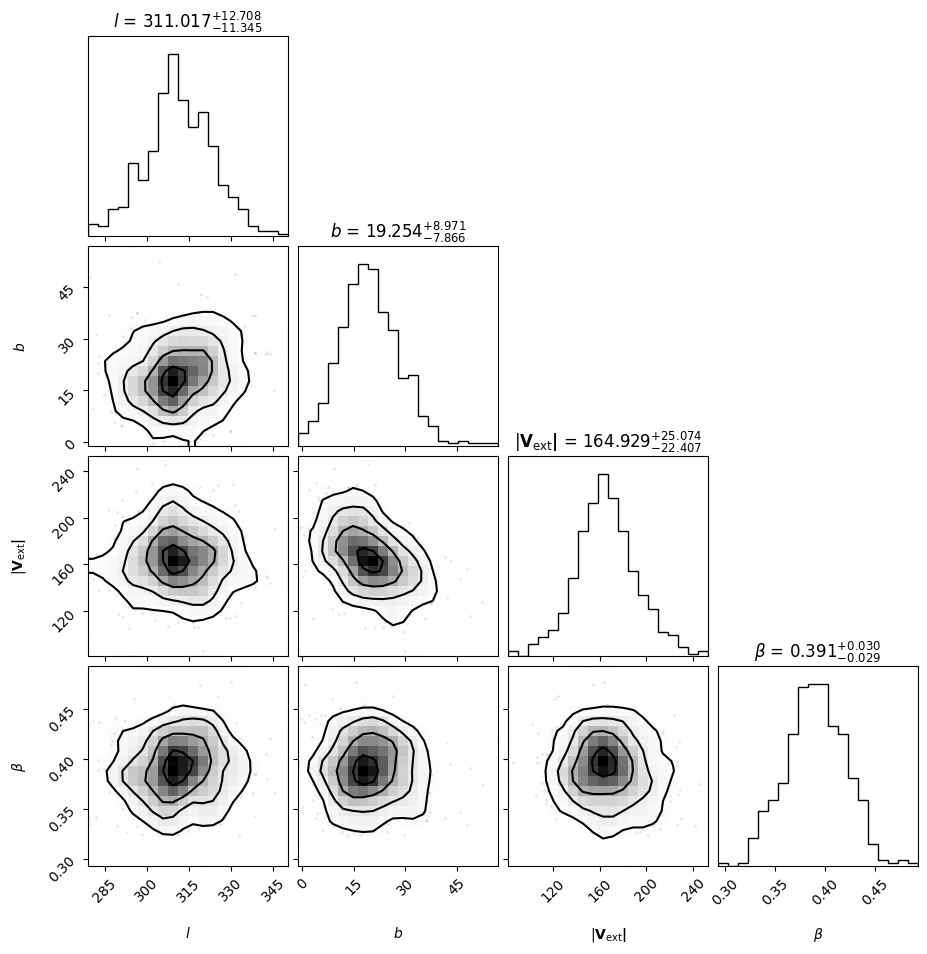

In [50]:
data = [l, b, Vmag]
labels = [r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]
if "alpha" in samples:
    data.append(samples["alpha"])
    labels.append(r"$\alpha$")

if "beta" in samples:
    data.append(samples["beta"])
    labels.append(r"$\beta$")

data = np.vstack(data).T
fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

## Vizualize the results

####  Functions to read in the results


Reading Foundation fitted to Carrick2015 with ksmooth = 0.


BIC  = 1852.867188 +- 0.000000
AIC  = 1824.664429 +- 0.000000
logZ = -897.537476 +- 0.000000
chi2 = 0.000000 +- 0.000000


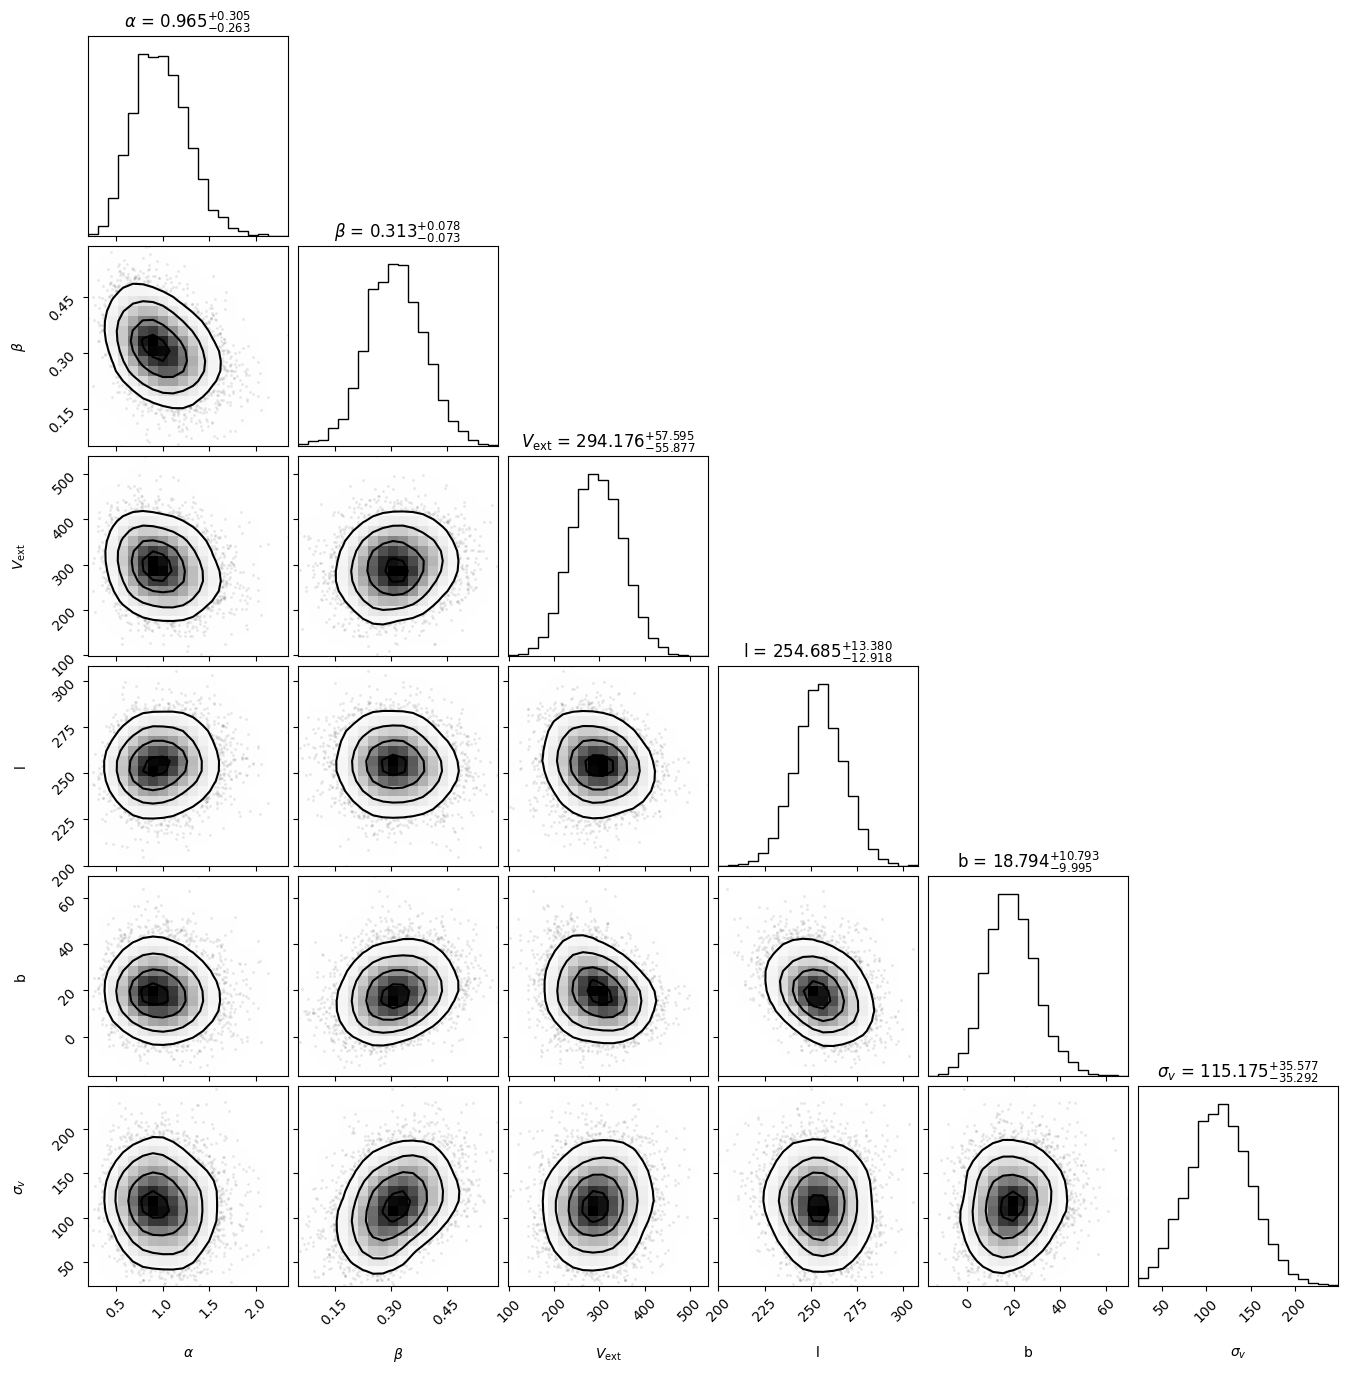

In [24]:
data, names, gof = read_samples("Foundation", "Carrick2015", 0)

fig = corner.corner(data, labels=names_to_latex(names, True), show_titles=True,
                    title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

### LOSS-only comparison

In [ ]:
LOSS_Carrick_0 = read_samples("LOSS", "Carrick2015", 0, return_MCsamples=True)
LOSS_Carrick_1 = read_samples("LOSS", "Carrick2015", 1, return_MCsamples=True)

LOSS_CB1_0 = read_samples("LOSS", "csiborg1", 0, return_MCsamples=True)
LOSS_CB1_1 = read_samples("LOSS", "csiborg1", 1, return_MCsamples=True)

LOSS_CB2_0 = read_samples("LOSS", "csiborg2_main", 0, return_MCsamples=True)
LOSS_CB2_1 = read_samples("LOSS", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
     LOSS_Carrick_0,
     # LOSS_Carrick_1,
     # LOSS_CB1_0,
     LOSS_CB1_1,
     LOSS_CB2_0,
     LOSS_CB2_1,
     ]

# params = ["l", "b", "Vmag", "beta"]
params = None

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right', )
g.export(f"../plots/LOSS_comparison.png", dpi=500,)


### Foundation-only comparison

In [ ]:
FOUNDATION_Carrick_0 = read_samples("Foundation", "Carrick2015", 0, return_MCsamples=True)
FOUNDATION_Carrick_1 = read_samples("Foundation", "Carrick2015", 1, return_MCsamples=True)

FOUNDATION_CB1_0 = read_samples("Foundation", "csiborg1", 0, return_MCsamples=True)
FOUNDATION_CB1_1 = read_samples("Foundation", "csiborg1", 1, return_MCsamples=True)

FOUNDATION_CB2_0 = read_samples("Foundation", "csiborg2_main", 0, return_MCsamples=True)
FOUNDATION_CB2_1 = read_samples("Foundation", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    FOUNDATION_Carrick_0,
    # FOUNDATION_Carrick_1,
    # FOUNDATION_CB1_0,
    FOUNDATION_CB1_1,
    FOUNDATION_CB2_0,
    FOUNDATION_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/FOUNDATION_comparison.png", dpi=500,)

### PantheonPlus-only comparison

In [58]:
# PANTHEONP_Carrick_0 = read_samples("Pantheon+", "Carrick2015", 0, return_MCsamples=True)
# PANTHEONP_Carrick_1 = read_samples("Pantheon+", "Carrick2015", 1, return_MCsamples=True)

# PANTHEONP_CB1_0 = read_samples("Pantheon+", "csiborg1", 0, return_MCsamples=True)
# PANTHEONP_CB1_1 = read_samples("Pantheon+", "csiborg1", 1, return_MCsamples=True)

# STILL RUNNING
PANTHEONP_CB2_0 = read_samples("Pantheon+", "csiborg2_main", 0, return_MCsamples=True)
PANTHEONP_CB2_1 = read_samples("Pantheon+", "csiborg2_main", 1, return_MCsamples=True)



Reading Pantheon+ fitted to csiborg2_main with ksmooth = 0.


BIC  = 10056.015674 +- 27.407189
AIC  = 10010.824268 +- 27.407189
logZ = -5006.756958 +- 48.432771
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading Pantheon+ fitted to csiborg2_main with ksmooth = 1.
BIC  = 10027.133105 +- 13.850270
AIC  = 9981.941699 +- 13.850270
logZ = -4981.690186 +- 6.885272
chi2 = 0.000000 +- 0.000000
Removed no burn in


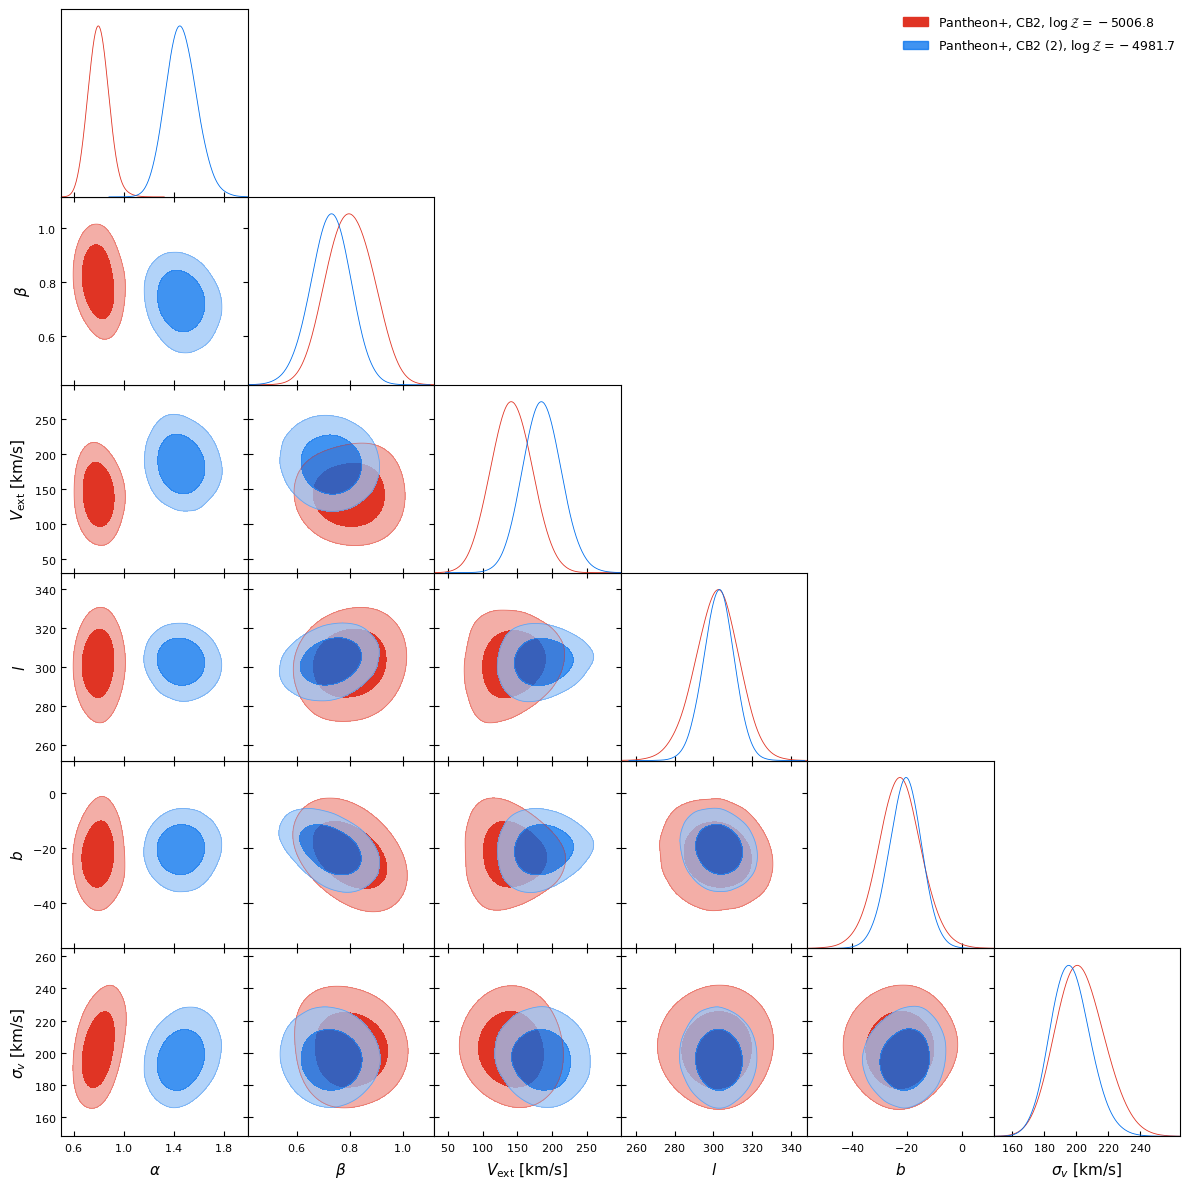

In [59]:
X = [
    # PANTHEONP_Carrick_0,
    # PANTHEONP_Carrick_1,
    # PANTHEONP_CB1_0,
    # PANTHEONP_CB1_1,
    PANTHEONP_CB2_0,
    PANTHEONP_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
# g.export(f"../plots/PANTHEONP_comparison.png", dpi=500,)

### 2MTF comparison

In [ ]:
TWOMTF_Carrick_0 = read_samples("2MTF", "Carrick2015", 0, return_MCsamples=True)
TWOMTF_Carrick_1 = read_samples("2MTF", "Carrick2015", 1, return_MCsamples=True)

TWOMTF_CB1_0 = read_samples("2MTF", "csiborg1", 0, return_MCsamples=True)
TWOMTF_CB1_1 = read_samples("2MTF", "csiborg1", 1, return_MCsamples=True)

TWOMTF_CB2_0 = read_samples("2MTF", "csiborg2_main", 0, return_MCsamples=True)
TWOMTF_CB2_1 = read_samples("2MTF", "csiborg2_main", 1, return_MCsamples=True)


In [ ]:
X = [
    TWOMTF_Carrick_0,
    # TWOMTF_Carrick_1,
    # TWOMTF_CB1_0,
    TWOMTF_CB1_1,
    TWOMTF_CB2_0,
    TWOMTF_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/2MTF_comparison.png", dpi=500,)

### SFI galaxies

In [ ]:
SFIGAL_Carrick_0 = read_samples("SFI_gals", "Carrick2015", 0, return_MCsamples=True)
SFIGAL_Carrick_1 = read_samples("SFI_gals", "Carrick2015", 1, return_MCsamples=True)

# SFIGAL_CB1_0 = read_samples("SFI_gals", "csiborg1", 0, return_MCsamples=True)
# SFIGAL_CB1_1 = read_samples("SFI_gals", "csiborg1", 1, return_MCsamples=True)

SFIGAL_CB2_0 = read_samples("SFI_gals", "csiborg2_main", 0, return_MCsamples=True)
SFIGAL_CB2_1 = read_samples("SFI_gals", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    SFIGAL_Carrick_0,
    # SFIGAL_Carrick_1,
    # SFIGAL_CB1_0,
    # SFIGAL_CB1_1,
    # SFIGAL_CB2_0,
    SFIGAL_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/SFI_gals_comparison.png", dpi=500,)

### External flow consistency

#### Carrick2015

In [ ]:
X = [
    # LOSS_Carrick_0,
    # FOUNDATION_Carrick_0,
    PANTHEONP_Carrick_0,
    TWOMTF_Carrick_0,
    SFIGAL_Carrick_0,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/Carrick2015_external_flow.png", dpi=500,)

#### CSiBORG1

In [ ]:
X = [
    # LOSS_CB1_1,
    # FOUNDATION_CB1_1,
    PANTHEONP_CB1_1,
    TWOMTF_CB1_1,
    # SFIGAL_CB1_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB1_external_flow.png", dpi=500,)

#### CSiBORG2

In [ ]:
X = [
    # LOSS_CB2_1,
    # FOUNDATION_CB2_1,
    PANTHEONP_CB2_1,
    TWOMTF_CB2_1,
    SFIGAL_CB2_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB2_external_flow.png", dpi=500,)

In [25]:
k = 1
LG = 0

# Carrick
# LOSS_Carrick_LG = read_samples("LOSS", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# FOUNDATION_Carrick_LG = read_samples("Foundation", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
PANTHEON_Carrick_LG = read_samples("Pantheon+", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# TWOMTF_Carrick_LG = read_samples("2MTF", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# SFIGAL_Carrick_LG = read_samples("SFI_gals", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)


# # CSiBORG2
# LOSS_CB2_LG = read_samples("LOSS", "csiborg2_main", k, return_MCsamples=True,subtract_LG_velocity=LG)
# FOUNDATION_CB2_LG = read_samples("Foundation", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_CB2_LG = read_samples("Pantheon+", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
# TWOMTF_CB2_LG = read_samples("2MTF", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
# SFIGAL_CB2_LG = read_samples("SFI_gals", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)

# # CSiBORG1
LOSS_CB1_LG = read_samples("LOSS", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
FOUNDATION_CB1_LG = read_samples("Foundation", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
PANTHEON_CB1_LG = read_samples("Pantheon+", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
TWOMTF_CB1_LG = read_samples("2MTF", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_CB1_LG = read_samples("SFI_gals", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)


Reading Pantheon+ fitted to Carrick2015 with ksmooth = 1.


Subtracting LG velocity with kernel 0.0 Mpc / h.
BIC  = 9990.192383 +- 0.000000
AIC  = 9945.000977 +- 0.000000
logZ = -4963.845215 +- 0.000000
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading LOSS fitted to csiborg1 with ksmooth = 1.
Subtracting LG velocity with kernel 0.0 Mpc / h.
BIC  = 776.321023 +- 4.885720
AIC  = 757.200783 +- 4.885720
logZ = -357.999639 +- 2.120405
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading Foundation fitted to csiborg1 with ksmooth = 1.
Subtracting LG velocity with kernel 0.0 Mpc / h.
BIC  = 1871.209213 +- 4.486214
AIC  = 1843.006454 +- 4.486214
logZ = -907.345996 +- 2.270922
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading Pantheon+ fitted to csiborg1 with ksmooth = 1.
Subtracting LG velocity with kernel 0.0 Mpc / h.
BIC  = 10165.661259 +- 17.568351
AIC  = 10120.469852 +- 17.568351
logZ = -5050.822299 +- 8.731843
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading 2MTF fitted to csiborg1 with ksmooth = 1.
Subtracting LG velocity w

Removed no burn in


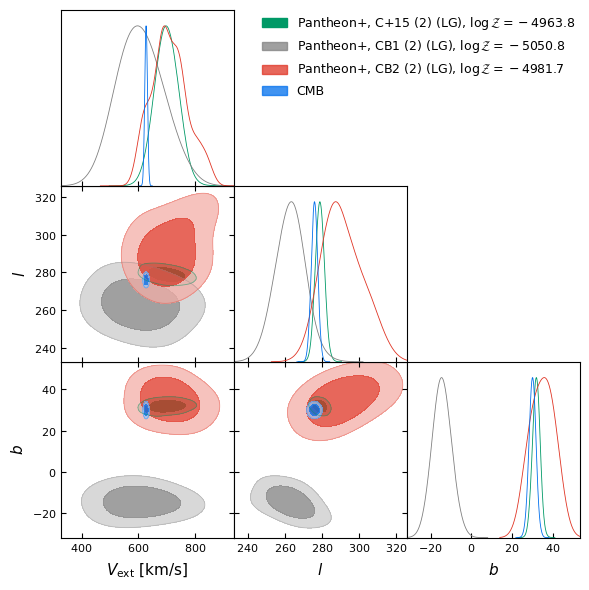

In [26]:
params = ["Vmag", "l", "b"]
CMB = MCSamples(samples=multivariate_normal([627, 276, 30], [22, 3, 3]).rvs(size=20000),
                names=params, labels=names_to_latex(params, True), label="CMB")

X = [
    # LOSS_Carrick_LG,
    # FOUNDATION_Carrick_LG,
    PANTHEON_Carrick_LG,
    # TWOMTF_Carrick_LG,
    # SFIGAL_Carrick_LG,
    # LOSS_CB1_LG,
    # FOUNDATION_CB1_LG,
    PANTHEON_CB1_LG,
    # TWOMTF_CB1_LG,
    # SFIGAL_CB1_LG,
    # LOSS_CB2_LG,
    # FOUNDATION_CB2_LG,
    PANTHEON_CB2_LG,
    # TWOMTF_CB2_LG,
    # SFIGAL_CB2_LG,
    CMB,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right', )
g.export(f"../plots/ALL_dipole.png", dpi=500,)